# Agent-Based Model (ABM) for Democratic Backsliding

Jochen Fromm, 2022

In [1]:
import pandas as pd
import numpy as np
import random

### The fitness

Simple 2x2 payoff matrix for cooperation game

In [2]:
PAYOFF = [2,0,0,2]

### The agents

Agents have two properties, "fitness" and "strategy", and interact according to a standard 2x2 payoff matrix from evolutionary game theory. "strategy" can have two values, 1 for "cooperators" and 0 for "critics". In our case these two values mean cooperate with regime or criticize the regime (i.e. cooperate with opponents).

In [3]:
COOPERATE = 1
CRITICIZE = 0

class Agent: 
  def __init__(self, s):
    self.fitness = 0
    self.strategy = s

  def reset(self):
    self.fitness = 0
      
  def interact(self, opponent, PAYOFF):
    self.fitness += PAYOFF[self.strategy*2+opponent.strategy]

In [4]:
a = Agent(0)
b = Agent(0)
c = Agent(1)
d = Agent(1)
a.interact(b, PAYOFF)
print("Agent A fitness", a.fitness)
print("Agent B fitness", b.fitness)
a.interact(c, PAYOFF)
print("Agent A fitness", a.fitness)
print("Agent c fitness", c.fitness)
c.interact(d, PAYOFF)
print("Agent c fitness", c.fitness)
print("Agent d fitness", d.fitness)

Agent A fitness 2
Agent B fitness 0
Agent A fitness 2
Agent c fitness 0
Agent c fitness 2
Agent d fitness 0


### The Agent-Based Model

In each generation agents which have fitness below average are eliminated because they are not well adapted to their environment (in our case for example because they are imprisoned or emigrate to avoid prison and persecution)

In [5]:
class AgentBasedModel:
  def __init__(self, cooperators, critics, PAYOFF):
    self.cooperators = cooperators
    self.critics = critics
    self.state = 0
    self.model = []
    self.data = []
    self.PAYOFF = PAYOFF
    for x in range(self.cooperators): self.model.append(Agent(COOPERATE))
    for x in range(self.critics): self.model.append(Agent(CRITICIZE))

  def play(self):
      total_number = len(self.model)
      i1 = random.randint(0, total_number-1)
      i2 = i1
      while (i1 == i2):
        i2 = random.randint(0, total_number-1)
      agent1 = self.model[i1]
      agent2 = self.model[i2]
      agent1.interact(agent2, self.PAYOFF)
      agent2.interact(agent1, self.PAYOFF)

  def count_cooperators(self):
      cooperators = [1 for agent in self.model if agent.strategy == COOPERATE]
      return sum(cooperators)

  def avergate_fitness(self):
      fitness = [agent.fitness for agent in self.model]
      return sum(fitness) / (len(self.model) * 1.0)

  def new_generation(self, generation):
      total_number = len(self.model)
      avg_fitness = self.avergate_fitness()
      # print("avg_fitness", avg_fitness)   
    
      # eliminate agents which have fitness below average 
      new_model = [Agent(agent.strategy) for agent in self.model if (agent.fitness > avg_fitness)]
      new_count = len(new_model)
      new_agents = total_number - new_count
      # msg = f"New generation {generation}. {new_count} agents from {total_number} have replicated. {new_agents} new agents"
      # print(msg)
        
      self.model = new_model
      for x in range(new_agents): 
         i = random.randint(0, new_count-1)
         strategy = self.model[i].strategy
         self.model.append(Agent(strategy))

  def run(self, generation_time, timesteps):
    generation_no = 0
    generations = int(timesteps / generation_time) - 1
    self.data = np.arange(generations * 3).reshape(generations,3)
    for t in range(timesteps):
      self.play()       
      self.state = self.count_cooperators() / len(self.model)
        
      if (t > 0) & ((t % generation_time) == 0):
        generation_no += 1
        self.new_generation(generation_no)
        self.data[generation_no-1] = np.array([t/30, generation_no, self.state * 100])
        # print(np.array([t, generation_no, self.state * 100]))

In [6]:
initial_state = 42
generation_time = 100
timesteps = 1000
generations = int(timesteps / generation_time) - 1
model_runs = 20

In [7]:
PAYOFF = [2,0,0,1]
model_1_data = np.arange(model_runs*generations*3).reshape(model_runs, generations, 3)

for n in range(model_runs):
  x = AgentBasedModel(initial_state, 100 - initial_state, PAYOFF)
  x.run(generation_time, timesteps)  
  model_1_data[n] = x.data

In [8]:
PAYOFF = [2,0,0,2]
model_2_data = np.arange(model_runs*generations*3).reshape(model_runs, generations, 3)

for n in range(model_runs):
  x = AgentBasedModel(initial_state, 100 - initial_state, PAYOFF)
  x.run(generation_time, timesteps)  
  model_2_data[n] = x.data

In [9]:
PAYOFF = [1,0,0,2]
model_3_data = np.arange(model_runs*generations*3).reshape(model_runs, generations, 3)

for n in range(model_runs):
  x = AgentBasedModel(initial_state, 100 - initial_state, PAYOFF)
  x.run(generation_time, timesteps)  
  model_3_data[n] = x.data

In [10]:
df = pd.DataFrame(model_1_data[0], columns=['Time', 'Generation', 'State'])
df.head(10)

,Time,Generation,State
0,3,1,42
1,6,2,20
2,10,3,0
3,13,4,0
4,16,5,0
5,20,6,0
6,23,7,0
7,26,8,0
8,30,9,0


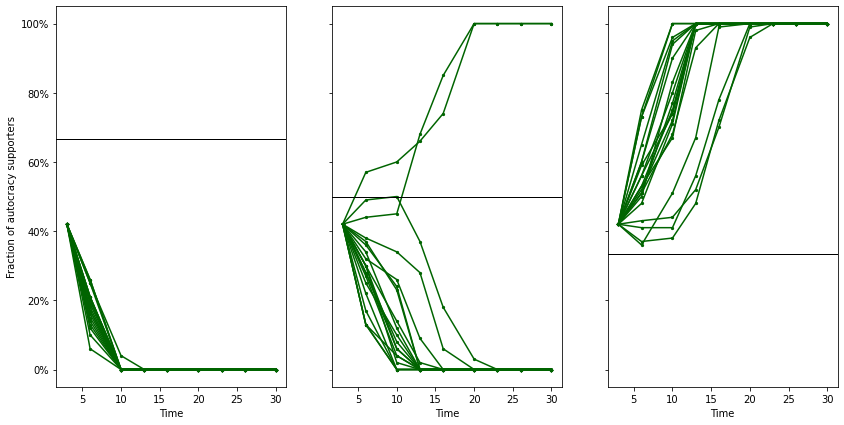

In [11]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
fig, ax = plt.subplots(1, 3, figsize=(14, 7), sharey=True)
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(100,0))
ax[0].set_ylabel("Fraction of autocracy supporters")

for n in range(model_runs):
  df = pd.DataFrame(model_1_data[n], columns=['Time', 'Generation', 'State'])
  ax[0].plot(df.Time, df.State, color="DarkGreen")
  ax[0].scatter(df.Time, df.State, s=5, color="DarkGreen")
  ax[0].axhline(y=66.7, color='black', linewidth=0.5)
  ax[0].set_xlabel("Time")

  df = pd.DataFrame(model_2_data[n], columns=['Time', 'Generation', 'State'])
  ax[1].plot(df.Time, df.State, color="DarkGreen")
  ax[1].scatter(df.Time, df.State, s=5, color="DarkGreen")
  ax[1].axhline(y=50, color='black', linewidth=0.5)
  ax[1].set_xlabel("Time")

  df = pd.DataFrame(model_3_data[n], columns=['Time', 'Generation', 'State'])
  ax[2].plot(df.Time, df.State, color="DarkGreen")
  ax[2].scatter(df.Time, df.State, s=5, color="DarkGreen")
  ax[2].axhline(y=33.3, color='black', linewidth=0.5)
  ax[2].set_xlabel("Time")

plt.show()

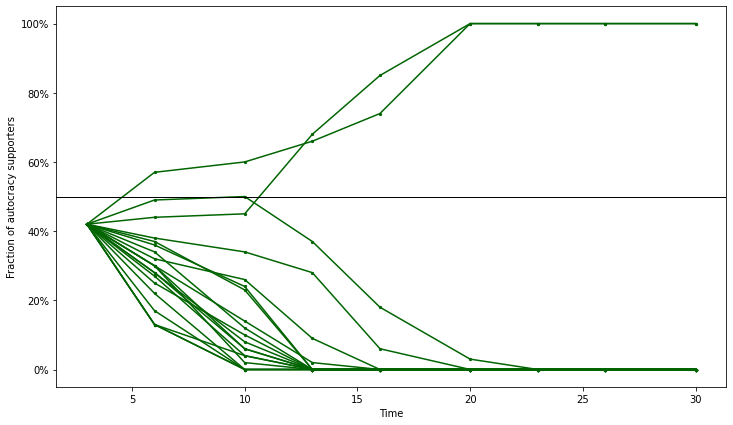

In [12]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100,0))
ax.set_ylabel("Fraction of autocracy supporters")

for n in range(model_runs):
  df = pd.DataFrame(model_2_data[n], columns=['Time', 'Generation', 'State'])
  ax.plot(df.Time, df.State, color="DarkGreen")
  ax.scatter(df.Time, df.State, s=5, color="DarkGreen")
  ax.axhline(y=50, color='black', linewidth=0.5)
  ax.set_xlabel("Time")

plt.show()